In [1]:
import numpy as np

from graphviz import Digraph
import networkx as nx
import networkx.algorithms as nxa
import re
import DeBruijnDNA
import matplotlib.pyplot as plt

In [2]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler
from dimod import ExactSolver, SimulatedAnnealingSampler, IdentitySampler

In [3]:
# 
# DーWave Local Solver
# ローカルでイジング問題を解くためのソルバー

#
def solve_dwave_local(Q, API_KEY):
    """
    ローカルマシンのシミュレーテッドアニーリングでイジング問題を解く
    Parameters
    ----------
    Q : List
        qubo配列
    API_KEY : String
        D-Wave呼び出しのためのAPI Key
    Returns
    -------
    Qubo計算の結果
    Notes
    -----
    """
    q = {}
    size = len(Q)
    for i in range(size):
        for j in range(size):
            q[(i,j)] = Q[i][j]
    #print(q)
    sampler = SimulatedAnnealingSampler()
    response = sampler.sample_qubo(q)

    result = []
    for sample, energy in response.data(['sample', 'energy']): 
        result.append(sample)
        result.append(energy)

    result.append(response.info) # view timings
    
    return result

In [4]:
import dimod
import hybrid
def solve_dwave(Q, API_KEY):
    """
    S-Waveのハイブリッドソルバーでイジング問題を解く
    Parameters
    ----------
    Q : List
        qubo配列
    API_KEY : String
        D-Wave呼び出しのためのAPI Key
    Returns
    -------
    Qubo計算の結果
    Notes
    -----
    """
    q = {}
    size = len(Q)
    for i in range(size):
        for j in range(size):
            q[(i,j)] = Q[i][j]
    bqm = dimod.BinaryQuadraticModel({}, q, 0, dimod.BINARY)
    # Define the workflow
    iteration = hybrid.RacingBranches(
        hybrid.InterruptableTabuSampler(),
        hybrid.EnergyImpactDecomposer(size=2)
        | hybrid.QPUSubproblemAutoEmbeddingSampler()
        | hybrid.SplatComposer()
    ) | hybrid.ArgMin()
    workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=3)

    # Solve the problem
    init_state = hybrid.State.from_problem(bqm)
    final_state = workflow.run(init_state).result()

    # Print results
    print("Solution: sample={.samples.first}".format(final_state))
    return final_state['samples'].first

## 1. Hamiltonian path De Bruijn graph

solve 676 ising problem
[[-1.  1.  1. ...  0.  0.  0.]
 [ 1. -1.  1. ...  0.  0.  0.]
 [ 1.  1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1.  1.]
 [ 0.  0.  0. ...  1. -1.  1.]
 [ 0.  0.  0. ...  1.  1. -1.]]


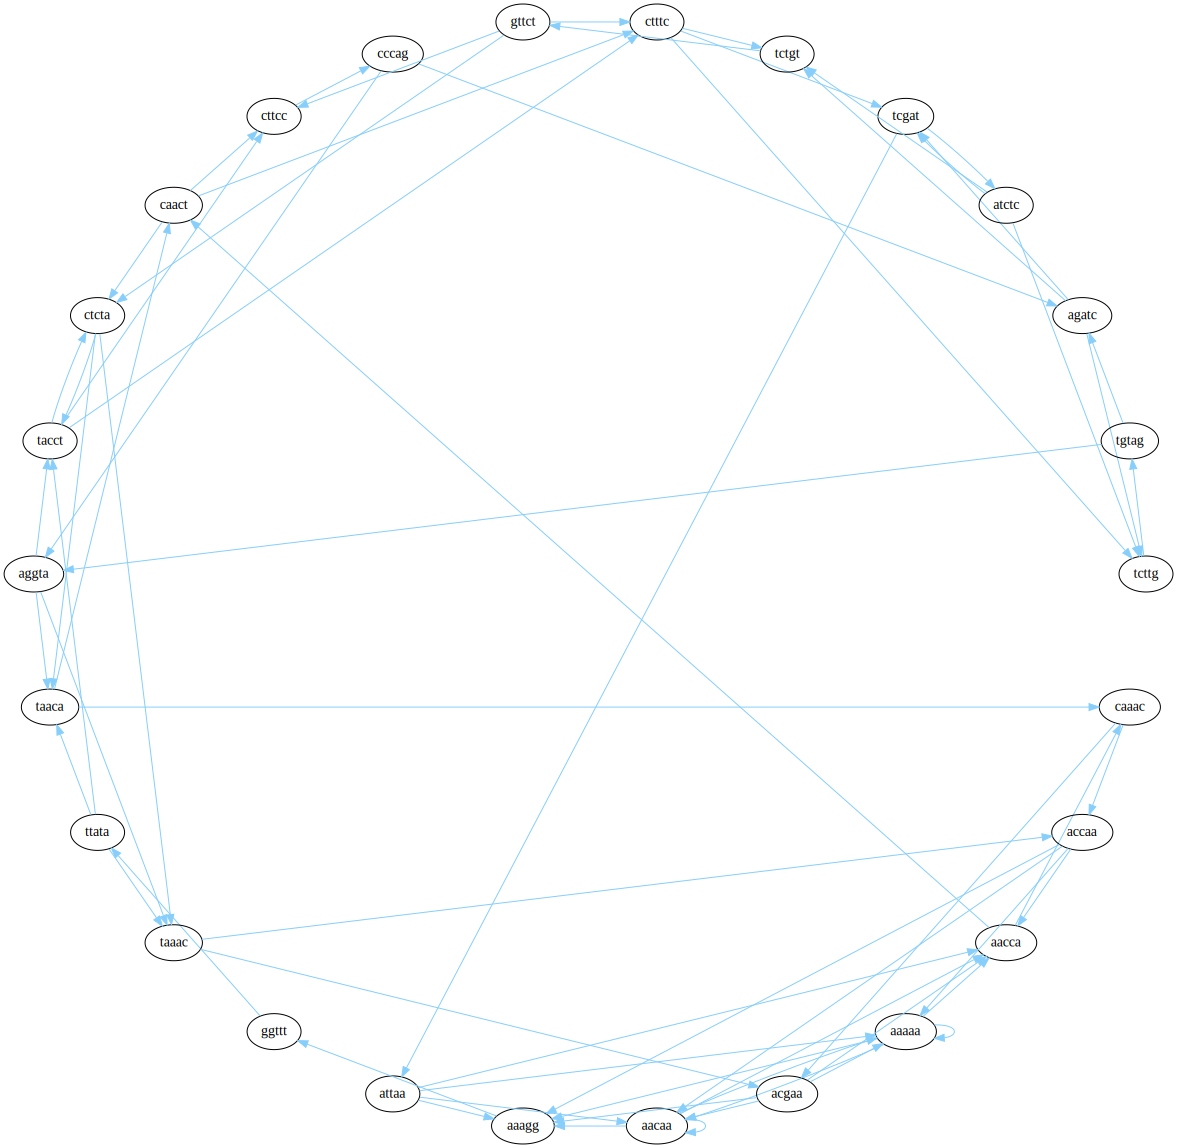

In [5]:
seq = 'CATACACCTAA'
seq = 'CATAGCACCGTAAGAATGCAGGTAC'
seq = 'attaaaggtttataccttcccaggtaacaaaccaaccaactttcgatctcttgtagatctgttctctaaacgaacaaaaaattaaagccaggaan'
seq = 'attaaaggtttataccttcccaggtaacaaaccaaccaactttcgatctcttgtagatctgttctctaaacgaacaaaaa'
#seq = 'caactttcgatctcttgtagatctgtt'
#seq = 'attaaaggtttataccttcccagg'
#seq = 'ggtttataccttcccaggt'

# seq='ATGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGC'
# seq='ATGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGC'
kmer_len, suffix_len = 5, 2 # 文字数は5、サフィックスは２バイト
adj, node_labels = DeBruijnDNA.make_debr(seq, kmer_len=kmer_len, suffix_len=suffix_len)
#print(adj, '\n', node_labels)
g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, [], kmer_len = kmer_len)
g.engine = 'circo'
Q = DeBruijnDNA.to_qubo(adj)
print('solve', len(Q) , 'ising problem')

print(Q)
g

In [6]:
target_energy = -np.sqrt(len(Q))
%time solution = solve_dwave(Q, API_KEY='DUMMY')
spins, energy = [solution[0][i] for i in solution[0].keys()], solution[1]
print(spins, energy)
g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, path_spins=spins, kmer_len=kmer_len)
g.engine = 'circo'
#g

Solution: sample=Sample(sample={0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 1, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 1, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 1, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0

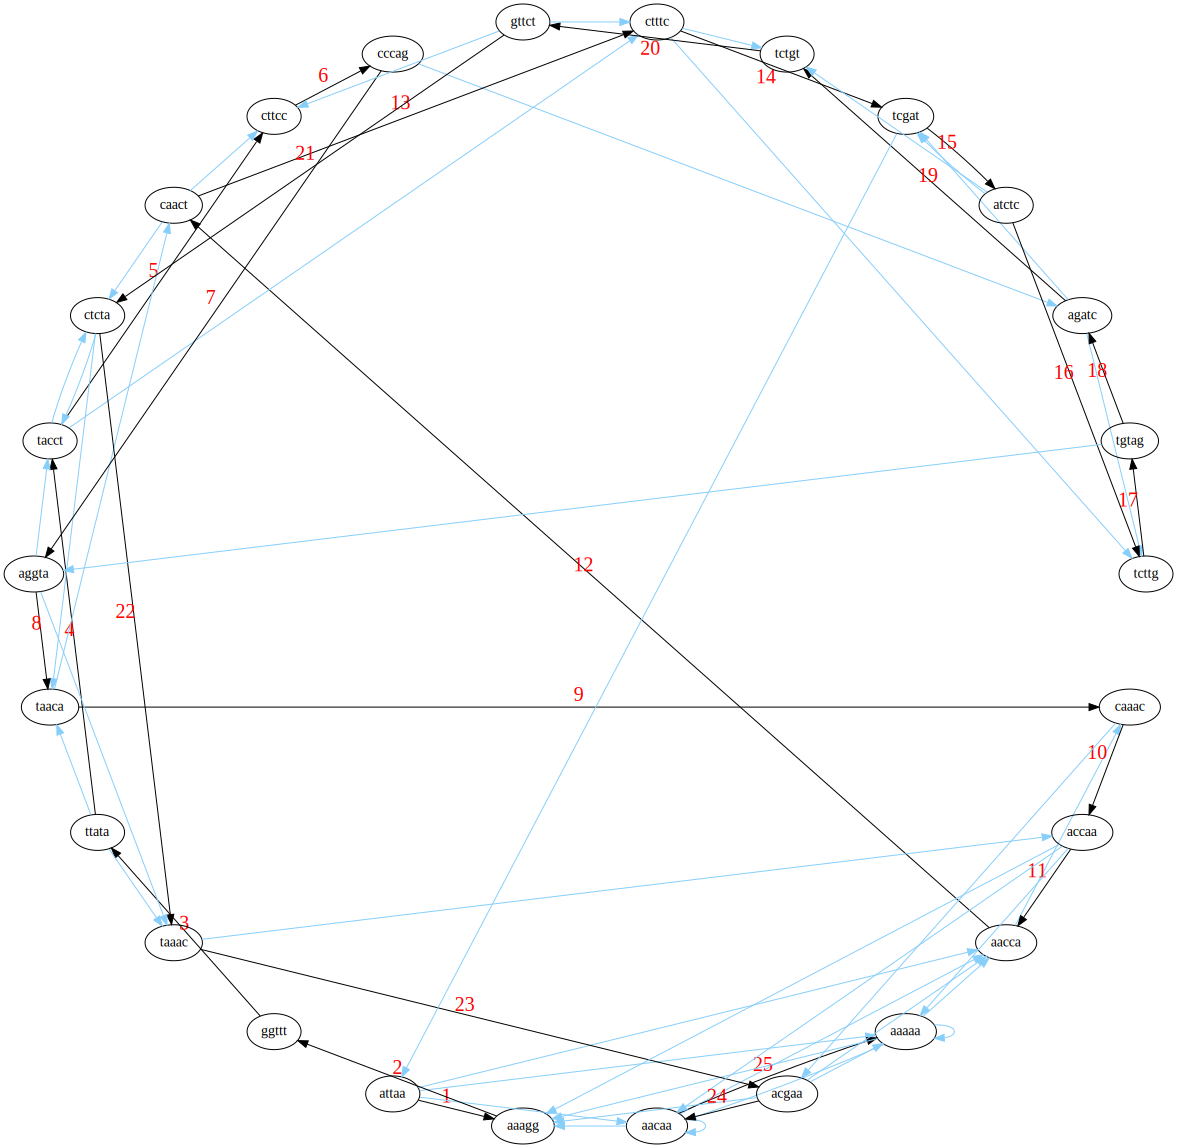

In [7]:
g